In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.8 MB/s eta 0:00:00


In [2]:
import os
import shutil
import random
import json
import glob
import re
import numpy as np
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab import drive
import yaml
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)


In [5]:

BASE_DIR = "/content/drive/Othercomputers/ה-Mac שלי/StormVision"


PAIRED_DIR = os.path.join(BASE_DIR, "storm_synth_out_onefolder/Combination")
ORIG_COCO_TRAIN = os.path.join(BASE_DIR, "data/annotations/instances_train.json")
ORIG_COCO_VAL = os.path.join(BASE_DIR, "data/annotations/instances_val.json")
SYNTH_COCO = os.path.join(BASE_DIR, "storm_synth_out_onefolder/instances_synth.json")

# Output paths (Workspace)
WORK_DIR = os.path.join(BASE_DIR, "output_dataset_pairs")
RUNS_DIR = os.path.join(BASE_DIR, "output_runs_stormvision")


if os.path.exists(WORK_DIR):
    print(f"Removing old work directory: {WORK_DIR}...")
    shutil.rmtree(WORK_DIR)


os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(RUNS_DIR, exist_ok=True)

print("Setup complete. Workspace ready.")


Setup complete. Workspace ready.


###  Class mapping (COCO -> custom classes)
Maps multiple COCO category names into 2 training classes:
- `0 = person` (includes `swimmer`)
- `1 = boat` (includes jetski, buoy, life saving appliances)


In [6]:
# Map specific COCO categories to our custom classes
# Class 0: Person (includes swimmers)
# Class 1: Boat (includes jetskis, life saving appliances, buoys)
CLASS_MAPPING = {
    'person': 0, 'swimmer': 0,
    'boat': 1, 'jetski': 1, 'life_saving_appliances': 1, 'buoy': 1
}


###  Build YOLO dataset from paired images + COCO annotations
Creates a YOLO-ready dataset by:
- Loading COCO JSONs (orig train/val + synth)
- Converting COCO boxes to normalized YOLO labels
- Splitting by `pair_id` to avoid leakage (ORIG and SYNTH stay in the same split)
- Copying images into `images/{train,val,test}` and writing `labels/{train,val,test}`
- Writing `dataset.yaml` for Ultralytics

In [7]:
def process_dataset(paired_dir, work_dir, json_paths):
    print("Loading COCO Annotations...")
    idx_map = {'ORIG': {}, 'SYNTH': {}}

    # Helper function to load JSON and map annotations
    def load_json(path, target_dict):
        with open(path, 'r') as f:
            data = json.load(f)

        # Create map from local category ID to our custom ID (0 or 1)
        # NOTE: We only keep categories that appear in CLASS_MAPPING; everything else is ignored.
        local_id_map = {}
        for cat in data['categories']:
            cname = cat['name'].lower()
            if cname in CLASS_MAPPING:
                local_id_map[cat['id']] = CLASS_MAPPING[cname]

        # Map annotations to images
        img_lookup = {img['id']: img for img in data['images']}
        for ann in data['annotations']:
            cid = local_id_map.get(ann['category_id'])
            if cid is None:
                continue # Skip irrelevant classes

            img_info = img_lookup.get(ann['image_id'])
            if not img_info:
                continue

            fname = img_info['file_name']
            if fname not in target_dict:
                target_dict[fname] = {'w': img_info['width'], 'h': img_info['height'], 'boxes': []}

            # Convert COCO bbox [x, y, w, h] to YOLO format [class, x_center, y_center, w, h]
            x, y, w, h = ann['bbox']
            W, H = img_info['width'], img_info['height']

            # Normalize coordinates to [0,1] range for YOLO labels
            target_dict[fname]['boxes'].append([
                cid,
                (x + w/2)/W, (y + h/2)/H, w/W, h/H
            ])

    # Load all JSON files
    load_json(json_paths['orig_train'], idx_map['ORIG'])
    load_json(json_paths['orig_val'], idx_map['ORIG'])
    load_json(json_paths['synth'], idx_map['SYNTH'])

    print("Organizing Files and Splitting Dataset...")
    all_files = os.listdir(paired_dir)

    # Group files by Pair ID to prevent data leakage between splits
    # NOTE: This ensures ORIG/SYNTH from the same pair go to the same split.
    pair_dict = defaultdict(list)
    for f in all_files:
        if 'pair_' in f and f.endswith('.jpg'):
            # Extract Pair ID (e.g., pair_0001)
            match = re.search(r'(pair_\d+)_', f)
            if match:
                pair_dict[match.group(1)].append(f)

    pair_ids = sorted(list(pair_dict.keys()))
    random.shuffle(pair_ids)

    # Split Ratios: 70% Train, 15% Val, 15% Test
    n = len(pair_ids)
    splits = {
        'train': pair_ids[:int(n*0.7)],
        'val': pair_ids[int(n*0.7):int(n*0.85)],
        'test': pair_ids[int(n*0.85):]
    }

    counts = defaultdict(int)

    # Process each split
    for split_name, pids in splits.items():
        img_dir = os.path.join(work_dir, 'images', split_name)
        lbl_dir = os.path.join(work_dir, 'labels', split_name)
        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(lbl_dir, exist_ok=True)

        for pid in pids:
            for fname in pair_dict[pid]:
                # 1. Copy Image
                shutil.copy2(os.path.join(paired_dir, fname), os.path.join(img_dir, fname))

                # 2. Generate Label File
                # Determine type (ORIG or SYNTH) and extract real filename key
                ftype = 'ORIG' if 'ORIG' in fname else 'SYNTH'
                match_name = re.search(r'pair_\d+_(ORIG|SYNTH)_(.*)', fname)
                if match_name:
                    real_name = match_name.group(2)
                else:
                    continue

                # Retrieve annotation data
                data = idx_map[ftype].get(real_name)
                # Fallback: try appending .jpg extension if key lookup fails
                # NOTE: This handles cases where COCO file_name may include the extension while real_name does not.
                if not data and (real_name + '.jpg') in idx_map[ftype]:
                    data = idx_map[ftype][real_name + '.jpg']

                # Write YOLO .txt file if data exists
                if data:
                    txt_path = os.path.join(lbl_dir, fname.replace('.jpg', '.txt'))
                    with open(txt_path, 'w') as f:
                        for b in data['boxes']:
                            f.write(f"{b[0]} {b[1]:.6f} {b[2]:.6f} {b[3]:.6f} {b[4]:.6f}\n")
                    counts[split_name] += 1

    print(f"Processing Done. Created labels for: Train: {counts['train']}, Val: {counts['val']}, Test: {counts['test']}")

    # Create dataset.yaml for YOLO
    yaml_content = f"""
        path: {work_dir}
        train: images/train
        val: images/val
        test: images/test
        names:
          0: person
          1: boat
        """
    with open(os.path.join(work_dir, 'dataset.yaml'), 'w') as f:
        f.write(yaml_content)


###  Run dataset processing
Executes `process_dataset(...)` to actually build the YOLO folder structure and label files under `WORK_DIR`.


In [8]:
# Run the processing function
process_dataset(PAIRED_DIR, WORK_DIR, {
    'orig_train': ORIG_COCO_TRAIN,
    'orig_val': ORIG_COCO_VAL,
    'synth': SYNTH_COCO
})


Loading COCO Annotations...
Organizing Files and Splitting Dataset...
Processing Done. Created labels for: Train: 311, Val: 68, Test: 71


###  Train Model B (fine-tuning)
Loads pretrained `yolov8s.pt` and fine-tunes it on your 2-class dataset using high resolution (`imgsz=1024`) to help small object detection.


In [9]:
# Initialize a pre-trained YOLOv8s model
model_b = YOLO('yolov8s.pt')

print("Starting Training...")

# Train model on both classes (0 and 1) to learn distinction
results = model_b.train(
    data=os.path.join(WORK_DIR, 'dataset.yaml'),
    project=RUNS_DIR,
    name='Model_B_Final',
    epochs=25,
    imgsz=1024,      # Higher input resolution helps small-object detection (at higher compute cost).
    batch=8,
    patience=10,
    plots=False,
    exist_ok=True,
    verbose=True
)

print("Training Complete.")


Starting Training...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/Othercomputers/ה-Mac שלי/StormVision/output_dataset_pairs/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Model_B_Final, nbs=64, nms=False, opset=None, optimize=False

###  Evaluate baseline vs fine-tuned on Real vs Synthetic
Creates two test subsets (ORIG-only and SYNTH-only) and evaluates:
- Baseline model (pretrained YOLO)
- Fine-tuned model (your trained weights)
Outputs Precision, Recall, F1 (computed), and mAP50 into a DataFrame.


In [10]:


def create_subset_yaml(work_dir, base_yaml_path, filter_str):
    """Creates a temporary YAML file for a specific subset (ORIG or SYNTH)."""
    # 1. Find images matching the filter
    test_img_dir = os.path.join(work_dir, 'images/test')
    all_imgs = glob.glob(os.path.join(test_img_dir, "*.jpg"))
    subset_imgs = [img for img in all_imgs if filter_str in os.path.basename(img)]

    if not subset_imgs:
        print(f"Warning: No images found for filter '{filter_str}'")
        return None

    # 2. Create image list file (.txt)
    subset_txt_path = os.path.join(work_dir, f'test_{filter_str}.txt')
    with open(subset_txt_path, 'w') as f:
        f.write('\n'.join(subset_imgs))

    # 3. Create new YAML pointing to this list
    with open(base_yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    yaml_data['test'] = subset_txt_path
    yaml_data['val'] = subset_txt_path # For validation mode

    subset_yaml_path = os.path.join(work_dir, f'dataset_{filter_str}.yaml')
    with open(subset_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)

    return subset_yaml_path

def evaluate_model_on_split(model, yaml_path, split_name):
    """Runs validation and returns dict of metrics."""
    results = model.val(
        data=yaml_path,
        split='test',
        imgsz=1024,
        batch=8,
        verbose=False,
        plots=False,
        classes=[0] # Evaluate only class 0 (Person) to match the project focus.
    )
    p, r = results.box.mp, results.box.mr
    # Compute F1 from Precision/Recall (safe epsilon prevents division by zero).
    f1 = 2 * (p * r) / (p + r + 1e-6)
    return {
        'Precision': p,
        'Recall': r,
        'F1': f1,
        'mAP50': results.box.map50
    }

# --- Main Evaluation Flow ---

# Load Models
print("Loading Models...")
model_a = YOLO('yolov8s.pt') # Baseline
weights_path = os.path.join(RUNS_DIR, 'Model_B_Final/weights/best.pt')
if not os.path.exists(weights_path):
    raise FileNotFoundError("Model B weights not found. Did you run training?")
model_b = YOLO(weights_path) # Finetuned

# Prepare Subsets
base_yaml = os.path.join(WORK_DIR, 'dataset.yaml')
yaml_orig = create_subset_yaml(WORK_DIR, base_yaml, 'ORIG')
yaml_synth = create_subset_yaml(WORK_DIR, base_yaml, 'SYNTH')

# Container for results
eval_data = []

# Loop through scenarios
scenarios = [
    ('Real Data', yaml_orig),
    ('Synthetic Data', yaml_synth)
]

print("\nStarting Split Evaluation...")
for data_name, yaml_file in scenarios:
    if not yaml_file: continue

    print(f"\n--- Evaluating on {data_name} ---")

    # Model A (Baseline)
    print(f"   > Testing Baseline Model...")
    res_a = evaluate_model_on_split(model_a, yaml_file, data_name)
    res_a.update({'Model': 'Baseline', 'Data Type': data_name})
    eval_data.append(res_a)

    # Model B (Finetuned)
    print(f"   > Testing Finetuned Model...")
    res_b = evaluate_model_on_split(model_b, yaml_file, data_name)
    res_b.update({'Model': 'Finetuned', 'Data Type': data_name})
    eval_data.append(res_b)

# Create DataFrame
df_split = pd.DataFrame(eval_data)
print("\nEvaluation Complete. Data prepared for plotting.")
display(df_split.round(3))


Loading Models...

Starting Split Evaluation...

--- Evaluating on Real Data ---
   > Testing Baseline Model...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 301.0±199.8 MB/s, size: 750.3 KB)
val: Scanning /content/drive/Othercomputers/ה-Mac שלי/StormVision/output_dataset_pairs/labels/test... 45 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 45/45 285.4it/s 0.2s
val: New cache created: /content/drive/Othercomputers/ה-Mac שלי/StormVision/output_dataset_pairs/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 5.3it/s 1.1s
                   all         45        129      0.223      0.295      0.184     0.0729
Speed: 1.3ms preprocess, 9.8ms inference, 0.0ms loss, 1.1ms postprocess per image
   > Testing Finetuned Model...
Ultralytics 8.3

,Precision,Recall,F1,mAP50,Model,Data Type
0,0.223,0.295,0.254,0.184,Baseline,Real Data
1,0.745,0.620,0.677,0.657,Finetuned,Real Data
2,0.154,0.116,0.133,0.082,Baseline,Synthetic Data
3,0.584,0.550,0.567,0.483,Finetuned,Synthetic Data


###  Plot comparative graphs
Generates 2x2 bar plots (mAP50, Recall, Precision, F1) comparing Baseline vs Fine-tuned for Real vs Synthetic test data.


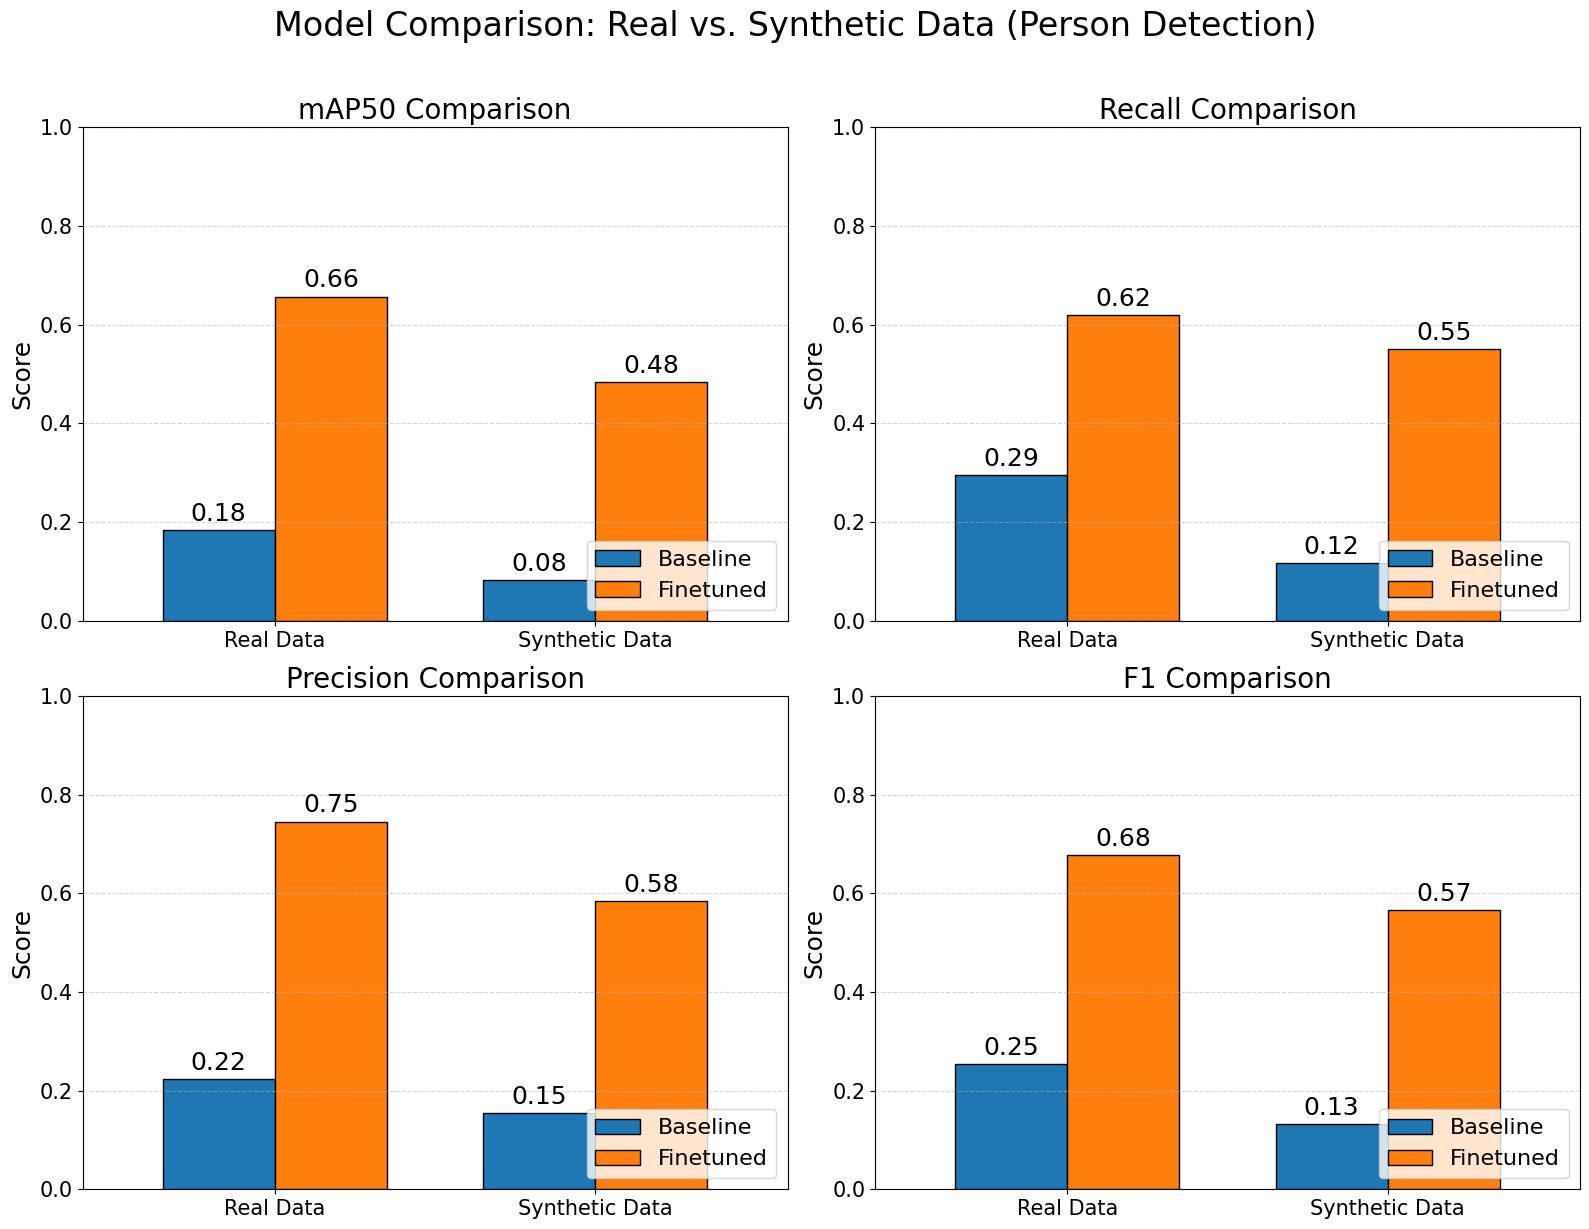

In [11]:


def plot_split_graphs(df):
    metrics = ['mAP50', 'Recall', 'Precision', 'F1']

    # Create 2x2 grid of plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()


    colors = {'Baseline': '#1f77b4', 'Finetuned': '#ff7f0e'} #

    for i, metric in enumerate(metrics):
        ax = axes[i]


        pivot_df = df.pivot(index='Data Type', columns='Model', values=metric)


        pivot_df.plot(kind='bar', ax=ax, color=[colors[c] for c in pivot_df.columns],
                      width=0.7, edgecolor='black', rot=0)


        ax.set_title(f'{metric} Comparison', fontsize=20)


        ax.set_ylabel('Score', fontsize=18)
        ax.set_xlabel('')


        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', linestyle='--', alpha=0.5)


        ax.legend(loc='lower right', fontsize=16)


        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=18)


    plt.suptitle("Model Comparison: Real vs. Synthetic Data (Person Detection)", fontsize=24, y=1.02)
    plt.tight_layout()
    plt.show()

if 'df_split' in locals() and not df_split.empty:
    plot_split_graphs(df_split)
else:
    print("No data to plot. Please run Cell 4 first.")


###  Visualize qualitative improvements (confidence gaps)
Scans test images to find cases where the fine-tuned model has significantly higher person-confidence than baseline, then displays side-by-side detection visualizations for top examples.







In [13]:
def visualize_improvements(model_a, model_b, work_dir, top_k=5):
    """
    Finds and plots test images where Model B has higher confidence than Model A.
    """
    test_img_dir = os.path.join(work_dir, 'images/test')
    test_files = glob.glob(os.path.join(test_img_dir, "*.jpg"))

    gap_cases = []
    print(f"Scanning {len(test_files)} test images for improvements...")

    for i, img_path in enumerate(test_files):
        im = cv2.imread(img_path)
        if im is None: continue

        # Run inference on both models, strictly for Class 0 (Person)
        res_a = model_a(im, verbose=False, classes=[0])[0]
        res_b = model_b(im, verbose=False, classes=[0])[0]

        # Get max confidence score for each model
        conf_a = res_a.boxes.conf.max().item() if len(res_a.boxes) > 0 else 0.0
        conf_b = res_b.boxes.conf.max().item() if len(res_b.boxes) > 0 else 0.0

        # Calculate confidence gap
        gap = conf_b - conf_a

        # Filter: Positive gap and Model B has decent confidence
        # These thresholds are heuristic and can be adjusted based on dataset difficulty.
        if gap > 0.1 and conf_b > 0.25:
            gap_cases.append((img_path, gap, conf_a, conf_b))

    # Sort by largest gap
    gap_cases.sort(key=lambda x: x[1], reverse=True)

    print(f"Found {len(gap_cases)} cases with significant improvement.")

    # Plot top K results
    for img_path, gap, ca, cb in gap_cases[:top_k]:
        im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        # Generate plots (bounding boxes)
        res_plot_a = model_a(im, verbose=False, classes=[0])[0].plot()
        res_plot_b = model_b(im, verbose=False, classes=[0])[0].plot()

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle(f"Improvement Gap: +{gap:.2f} (Baseline: {ca:.2f} -> Finetuned: {cb:.2f})", fontsize=16)

        ax[0].imshow(res_plot_a)
        ax[0].set_title("Baseline (Standard YOLO)")
        ax[0].axis('off')

        ax[1].imshow(res_plot_b)
        ax[1].set_title("Finetuned (Our Model)")
        ax[1].axis('off')

        plt.show()


visualize_improvements(model_a, model_b, WORK_DIR, top_k=10)


Output hidden; open in https://colab.research.google.com to view.